### Figure 1
- schematic
- spectrogram for NSD and SD
- percentage sleep fraction during first 5h of POST for both SD and NSD sessions


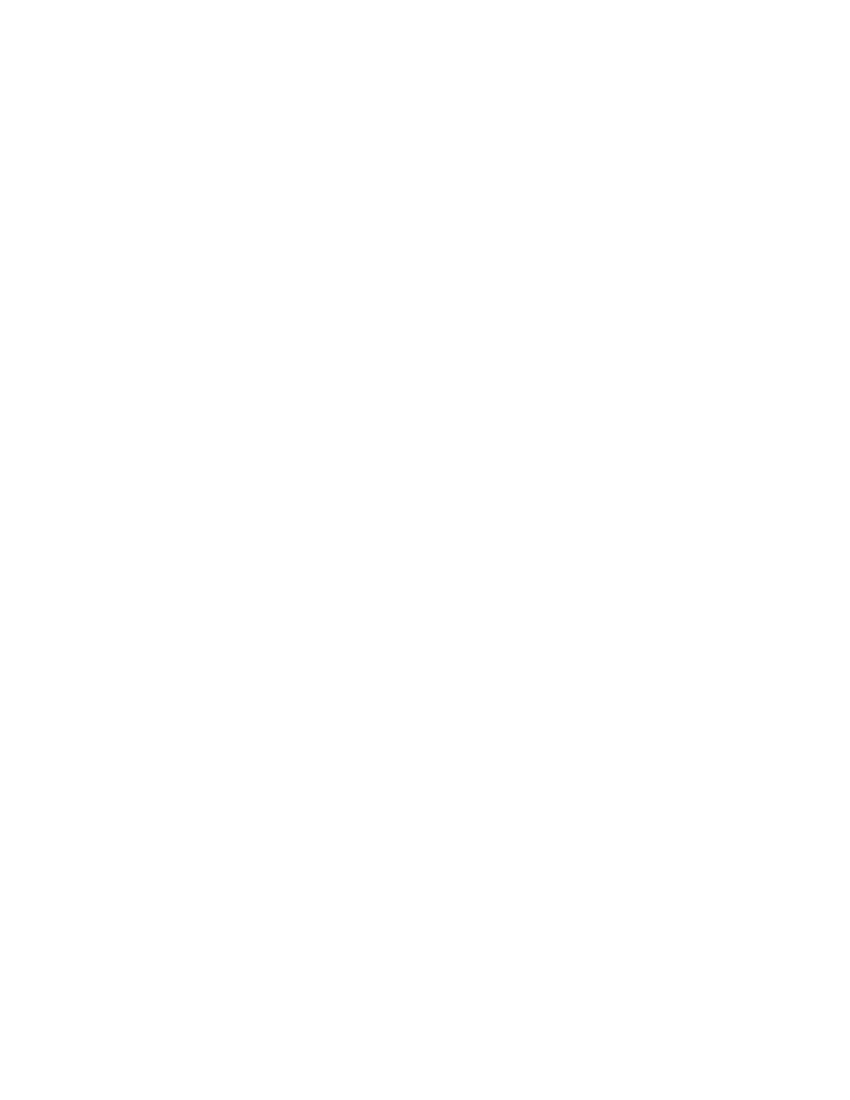

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import subjects
import pandas as pd
import seaborn as sns
from neuropy.plotting import Fig
from scipy import stats
from subjects import light_cycle_span,sns_boxplot_kw, stat_kw

grpdata = subjects.GroupData()
group = ["NSD", "SD"]

#SWA
swa,swa_time,swa_states = grpdata.swa_examples.values()
# brainstates 
states = grpdata.brainstates_proportion

#frate
frate = grpdata.frate_ratio_nsd_vs_sd
frate_inter = grpdata.frate_interneuron_around_Zt5
frate_change = grpdata.frate_change_1vs5
frate_change_pre_post = grpdata.frate_change_pre_to_post
colors_frate_change = subjects.colors_sd()

frate_quantiles = grpdata.frate_pre_to_maze_quantiles_in_POST
# frate_quantiles_shuffled= grpdata.frate_pre_to_maze_quantiles_in_POST_shuffled

# plt.clf()
fig = Fig(grid=(8,8),fontsize=7)

filename = subjects.figpath_sd / "figure1"

### SWA

In [86]:
from neuropy.plotting import plot_epochs

subfig = fig.fig.add_subfigure(fig.gs[0, :4])
axs = subfig.subplots(2, 2,sharey=True, gridspec_kw=dict(height_ratios=[1, 4]))
# axs[0].plot([1,2,3],[1,2,3])
# axs = axs.reshape(2, 2).T
for i in range(2):
    time = swa_time[i]

    plot_epochs(
        swa_states[i],
        ax=axs[0, i],
        labels_order=["nrem", "rem", "quiet", "active"],
        colors=subjects.colors_sleep_old,
    )
    # axs[0,i].set_xlim(time[0],time[-1])
    axs[0,i].set_xlim(0,8*3600)
    axs[0, i].axis("off")

    axs[1, i].plot(time, swa[i],color=subjects.colors_sd(0.9)[i],lw=1)
    # axs[1, i].step(time, swa[i],color=subjects.colors_sd(1.4)[i])
    # axs[1, i].fill_between(time, swa[i],color=subjects.colors_sd(1.4)[i],alpha=0.5)
    # axs[1, i].fill_between(time, swa[i],ec=subjects.colors_sd(1.5)[i],color=subjects.colors_sd(1.5)[i],alpha=0.6)
    axs[1,i].set_xlim(0,8*3600)
    axs[1,i].set_ylim(0,0.35)
    # if i ==0:
    #     axs[1,i].set_xticks([])
    # if i==1:
    xticks = np.arange(0,8,2)*3600+ time[0] 
    axs[1, i].set_xticks(xticks, np.arange(0,8,2))
    axs[1, i].set_xlabel('Zt time (h)')
    axs[1, i].set_ylabel('SWA (m$V^2$/Hz)')


### firing rate ratio across session

In [87]:
# neuron_colors = ["#f52e14", "#0a8a46"]
neuron_colors = [subjects.colors_sd(1), subjects.colors_sd(1)]
subfig = fig.fig.add_subfigure(fig.gs[2, :5])
axs = subfig.subplots(1, 2, sharex=True, sharey=True)
for i, neuron_type in enumerate(["pyr", "inter"]):
    ls = "--" if neuron_type == "inter" else "-"
    neur_color = neuron_colors[i]

    for i1, grp in enumerate(group):
        ax_frate = axs[i1]
        df = frate[
            (frate["grp"] == grp) & (frate["neuron_type"] == neuron_type)
        ].groupby("zt")

        color = subjects.colors_sd(0.8)[i1]

        y = df.mean().frate_ratio_perc
        x = y.index
        err = df.sem(ddof=0).frate_ratio_perc.values
        ax_frate.fill_between(
            x, y - err, y + err, color=color, alpha=0.3, ec=None, zorder=1
        )
        ax_frate.plot(x, y, color=color, lw=1, zorder=2, ls=ls)

        # baseline=====
        ax_frate.axhline(100, ls="--", color="#4d7ff5")

        light_cycle_span(ax_frate, -3.5, 8)
        # epoch_span(ax_frate)

        ax_frate.set_xlabel("ZT time (h)")
        ax_frate.set_xlim([-3.5, 8])

        # ax_frate.set_ylim([-1.2, 1.7])


### E/I ratio

In [88]:
# ax = fig.subplot(fig.gs[3,:2])
subfig = fig.fig.add_subfigure(fig.gs[3, :5])
axs = subfig.subplots(1,2,sharey=True)
ax = axs[0]

t = frate['zt'].unique()
for g, grp in enumerate(group):
    df = frate[frate['grp']==grp].groupby(['neuron_type','zt']).mean()
    ei_ratio = df.loc['pyr'].frate_ratio_perc/df.loc['inter'].frate_ratio_perc 

    ax.plot(t,ei_ratio,color=subjects.colors_sd(0.9)[g])

ax.set_xlim([-3.5,8])
light_cycle_span(ax, -3.5, 8)
ax.set_xticks(np.arange(-2,10,2))
ax.axhline(1, ls="--", color="#4d7ff5")
ax.set_xlabel('Zt time (h)')

Text(0.5, 0, 'Zt time (h)')

### Quantify ratio from PRE(baseline) to POST

In [89]:
from statannotations.Annotator import Annotator

for i, n in enumerate(["pyr", "inter"]):
    df = frate_change_pre_post[frate_change_pre_post["neuron_type"] == n]

    ax = fig.subplot(fig.gs[0, i + 4])
    plot_kw = dict(data=df, x="zt", y="frate_ratio", hue="grp", hue_order=group, ax=ax)
    sns.boxplot(**plot_kw, **sns_boxplot_kw)
    # sns.stripplot(**plot_kw,dodge=True,s=3)
    # ax.set_yscale('log')
    ax.legend("", frameon=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.tick_params("x", labelrotation=30)

    # stats
    stat_kw['verbose']=True
    orders = df.zt.unique()
    pairs = [((_, "NSD"), (_, "SD")) for _ in orders]
    annotator = Annotator(pairs=pairs, order=orders, **plot_kw)
    annotator.configure(test="t-test_ind", **stat_kw)
    annotator.apply_and_annotate()
    annotator.reset_configuration()

    # paired test in SD
    pairs = [(('0-2.5', "NSD"), ('2.5-5', "NSD")),(('0-2.5', "SD"), ('2.5-5', "SD"))]
    annotator = Annotator(pairs=pairs, order=orders, **plot_kw)
    annotator.configure(test="t-test_paired", **stat_kw)
    annotator.apply_and_annotate()
    annotator.reset_configuration()


    # stats against baseline
    for g,grp in enumerate(group):
        for t in orders:
            vals = df[(df.grp==grp)&(df.zt==t)].frate_ratio.values
            ttest = stats.ttest_1samp(vals,100,alternative='two-sided')
            print(grp,t,ttest.pvalue)


    ax.set_ylim(0, 500)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2.5-5_NSD vs. 2.5-5_SD: t-test independent samples, P_val:1.108e-01 t=-1.597e+00
0-2.5_NSD vs. 0-2.5_SD: t-test independent samples, P_val:4.065e-01 t=8.305e-01
5-7.5_NSD vs. 5-7.5_SD: t-test independent samples, P_val:7.800e-02 t=-1.765e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0-2.5_NSD vs. 2.5-5_NSD: t-test paired samples, P_val:2.487e-01 t=1.155e+00
0-2.5_SD vs. 2.5-5_SD: t-test paired samples, P_val:2.987e-03 t=-2.993e+00
NSD 0-2.5 2.2502639288956064e-14
NSD 2.5-5 1.301176287052574e-13
NSD 5-7.5 1.2508338491104065e-11
SD 0-2.5 1.7194269173971917e-10
SD 2.5-5 3.387647502270559e-11
SD 5-7.5 3.3054449628341873e-06
p-value annotation legend:
      ns: p <= 1.00e+00
 

### saving

In [90]:
# fig.savefig(filename)